In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import unicodedata
import plotly.express as px

## Loading Datasets  

In [2]:
world_bank_data = pd.read_csv("C:/Users/USER/Downloads/world_bank_development_indicators.csv")
income = pd.ExcelFile("C:/Users/USER/Downloads/income.xlsx")  # Example file name

## Fixing country names and merging 

In [3]:
def clean_country(x):
    if isinstance(x, str):
        x = x.strip().lower()
        x = ''.join(
            c for c in unicodedata.normalize('NFKD', x)
            if not unicodedata.combining(c)
        )
        return x
    return x

world_bank_data['country_clean'] = world_bank_data['country'].apply(clean_country)
income = income.parse(0)  # Read the first sheet from the ExcelFile
income['country_clean'] = income['Economy'].apply(clean_country)


In [4]:
regions = [
    'Middle East & North Africa',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'East Asia & Pacific (IDA & IBRD countries)',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Middle East & North Africa (excluding high income)',
    'Not classified',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Middle East & North Africa (IDA & IBRD)',
]

world_bank_data = world_bank_data[~world_bank_data['country'].isin(regions)]
income_df = income[~income['Economy'].isin(regions)]

In [5]:
mapping = {
    'viet nam': 'vietnam',
    'cote divoire': "cote d'ivoire",
    'somalia': 'somalia fed rep',
    'turkiye': 'turkey',
    'curacao': 'curacao',
    'sao tome and principe': 'sao tome e principe',
    'puerto rico': 'puerto rico us',
    # add more later if needed
}

world_bank_data['country_clean'] = world_bank_data['country_clean'].replace(mapping)
income_df['country_clean'] = income_df['country_clean'].replace(mapping)


In [6]:
merged = world_bank_data.merge(
    income_df[['country_clean', 'Region', 'Income group', 'Lending category']],
    on='country_clean',
    how='left'
)
df = merged

In [7]:
# find original position
pos = df.columns.get_loc('country')

# drop old country column
df = df.drop(columns=['country'])

# insert clean country column back in the same place
df.insert(pos, 'country', df['country_clean'])

# drop the old clean column
df = df.drop(columns=['country_clean'])


## Filling Missing Values with Forward and Backward Filling method 

In [8]:
cols_to_fill = [
    'agricultural_land%', 'forest_land%', 'land_area',
    'avg_precipitation', 'trade_in_services%', 'population_density',
    'birth_rate', 'death_rate', 'life_expectancy_at_birth'
]
df[cols_to_fill] = df[cols_to_fill].ffill().bfill()


## Filling Missing Values with median 

In [9]:
median_cols = [
    'trade_in_services%',
    'access_to_electricity%',
    'renewvable_energy_consumption%',
    'electric_power_consumption',
    'CO2_emisions',
    'other_greenhouse_emisions',
    'inflation_annual%',
    'real_interest_rate',
    'risk_premium_on_lending',
    'research_and_development_expenditure%',
    'central_goverment_debt%',
    'tax_revenue%',
    'expense%',
    'statistical_performance_indicators',
    'individuals_using_internet%',
    'gini_index',
    'population',
    'rural_population',
    'intentional_homicides'
]


# Fill missing values with the column median
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())


## Filling Missing Values with Mean 

In [10]:
mean_cols = [
    'goverment_effectiveness_estimate',
    'goverment_effectiveness_std',
    'human_capital_index',
    'military_expenditure%',
    'GDP_current_US',
    'political_stability_estimate',
    'political_stability_std',
    'rule_of_law_estimate',
    'rule_of_law_std',
    'regulatory_quality_estimate',
    'regulatory_quality_std',
    'government_expenditure_on_education%',
    'government_health_expenditure%',
    'control_of_corruption_estimate',
    'control_of_corruption_std',
    'voice_and_accountability_std'
]
# Fill with MEAN
for col in mean_cols:
    df[col] = df[col].fillna(df[col].mean())


## droping unnecessary columns 

In [11]:
cols_to_drop = [
    'doing_business',
    'time_to_get_operation_license',
    'logistic_performance_index',
    'multidimensional_poverty_headcount_ratio%',
    'voice_and_accountability_estimate',
    'Region',
    'Lending category'
]

df = df.drop(columns=cols_to_drop)


## checking missing values 

In [12]:
df.isnull().sum()

country                                     0
date                                        0
agricultural_land%                          0
forest_land%                                0
land_area                                   0
avg_precipitation                           0
trade_in_services%                          0
control_of_corruption_estimate              0
control_of_corruption_std                   0
access_to_electricity%                      0
renewvable_energy_consumption%              0
electric_power_consumption                  0
CO2_emisions                                0
other_greenhouse_emisions                   0
population_density                          0
inflation_annual%                           0
real_interest_rate                          0
risk_premium_on_lending                     0
research_and_development_expenditure%       0
central_goverment_debt%                     0
tax_revenue%                                0
expense%                          

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df

country        date  agricultural_land%  forest_land%  land_area  \
0      afghanistan  1960-01-01           57.878356      1.852782   652230.0   
1      afghanistan  1961-01-01           57.878356      1.852782   652230.0   
2      afghanistan  1962-01-01           57.955016      1.852782   652230.0   
3      afghanistan  1963-01-01           58.031676      1.852782   652230.0   
4      afghanistan  1964-01-01           58.116002      1.852782   652230.0   
...            ...         ...                 ...           ...        ...   
16724     zimbabwe  2019-01-01           41.876696     45.213002   386850.0   
16725     zimbabwe  2020-01-01           41.876696     45.093912   386850.0   
16726     zimbabwe  2021-01-01           41.876696     44.974822   386850.0   
16727     zimbabwe  2022-01-01           41.876696     44.974822   386850.0   
16728     zimbabwe  2023-01-01           41.876696     44.974822   386850.0   

       avg_precipitation  trade_in_services%  control_of_corruption_estimate  \
0                  327.0            5.941145                       -0.024874   
1                  327.0            5.941145                       -0.024874   
2                  327.0            5.941145                       -0.024874   
3                  327.0            5.941145                       -0.024874   
4                  327.0            5.941145                       -0.024874   
...                  ...                 ...                             ...   
16724              657.0            6.927164                       -1.271190   
16725              657.0            5.118949                       -1.287992   
16726              657.0            5.118949                       -1.253550   
16727              657.0            5.118949                       -1.255139   
16728              657.0            5.118949                       -0.024874   

       control_of_corruption_std  access_to_electricity%  ...  \
0                       0.203572               98.590855  ...   
1                       0.203572               98.590855  ...   
2                       0.203572               98.590855  ...   
3                       0.203572               98.590855  ...   
4                       0.203572               98.590855  ...   
...                          ...                     ...  ...   
16724                   0.133336               46.682095  ...   
16725                   0.140076               52.747667  ...   
16726                   0.151591               48.979927  ...   
16727                   0.151262               98.590855  ...   
16728                   0.203572               98.590855  ...   

       government_health_expenditure%  gini_index  birth_rate  death_rate  \
0                            3.246429        35.7      50.340      31.921   
1                            3.246429        35.7      50.443      31.349   
2                            3.246429        35.7      50.570      30.845   
3                            3.246429        35.7      50.703      30.359   
4                            3.246429        35.7      50.831      29.867   
...                               ...         ...         ...         ...   
16724                        0.522077        50.3      31.518       8.043   
16725                        0.756783        35.7      31.009       8.132   
16726                        3.246429        35.7      30.537       9.057   
16727                        3.246429        35.7      30.537       9.057   
16728                        3.246429        35.7      30.537       9.057   

       life_expectancy_at_birth  population  rural_population  \
0                        32.535   8622466.0         7898093.0   
1                        33.068   8790140.0         8026804.0   
2                        33.547   8969047.0         8163985.0   
3                        34.016   9157465.0         8308019.0   
4                        34.494   9355514.0         8458694.0   
...  

## display the first, the last and a random sample of 7 entries

In [15]:
df.head(7)

country        date  agricultural_land%  forest_land%  land_area  \
0  afghanistan  1960-01-01           57.878356      1.852782   652230.0   
1  afghanistan  1961-01-01           57.878356      1.852782   652230.0   
2  afghanistan  1962-01-01           57.955016      1.852782   652230.0   
3  afghanistan  1963-01-01           58.031676      1.852782   652230.0   
4  afghanistan  1964-01-01           58.116002      1.852782   652230.0   
5  afghanistan  1965-01-01           58.123668      1.852782   652230.0   
6  afghanistan  1966-01-01           58.192662      1.852782   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  \
0              327.0            5.941145                       -0.024874   
1              327.0            5.941145                       -0.024874   
2              327.0            5.941145                       -0.024874   
3              327.0            5.941145                       -0.024874   
4              327.0            5.941145                       -0.024874   
5              327.0            5.941145                       -0.024874   
6              327.0            5.941145                       -0.024874   

   control_of_corruption_std  access_to_electricity%  ...  \
0                   0.203572               98.590855  ...   
1                   0.203572               98.590855  ...   
2                   0.203572               98.590855  ...   
3                   0.203572               98.590855  ...   
4                   0.203572               98.590855  ...   
5                   0.203572               98.590855  ...   
6                   0.203572               98.590855  ...   

   government_health_expenditure%  gini_index  birth_rate  death_rate  \
0                        3.246429        35.7      50.340      31.921   
1                        3.246429        35.7      50.443      31.349   
2                        3.246429        35.7      50.570      30.845   
3                        3.246429        35.7      50.703      30.359   
4                        3.246429        35.7      50.831      29.867   
5                        3.246429        35.7      50.872      29.389   
6                        3.246429        35.7      50.986      28.872   

   life_expectancy_at_birth  population  rural_population  \
0                    32.535   8622466.0         7898093.0   
1                    33.068   8790140.0         8026804.0   
2                    33.547   8969047.0         8163985.0   
3                    34.016   9157465.0         8308019.0   
4                    34.494   9355514.0         8458694.0   
5                    34.953   9565147.0         8617815.0   
6                    35.453   9783147.0         8782038.0   

   voice_and_accountability_std  intentional_homicides  Income group  
0                      0.167144               3.391501    Low income  
1                      0.167144               3.391501    Low income  
2                      0.167144               3.391501    Low income  
3                      0.167144               3.391501    Low income  
4                      0.167144               3.391501    Low income  
5                      0.167144               3.391501    Low income  
6                      0.167144               3.391501    Low income  

[7 rows x 46 columns]

In [16]:
df.tail(7)

country        date  agricultural_land%  forest_land%  land_area  \
16722  zimbabwe  2017-01-01           41.876696     45.451183   386850.0   
16723  zimbabwe  2018-01-01           41.876696     45.332093   386850.0   
16724  zimbabwe  2019-01-01           41.876696     45.213002   386850.0   
16725  zimbabwe  2020-01-01           41.876696     45.093912   386850.0   
16726  zimbabwe  2021-01-01           41.876696     44.974822   386850.0   
16727  zimbabwe  2022-01-01           41.876696     44.974822   386850.0   
16728  zimbabwe  2023-01-01           41.876696     44.974822   386850.0   

       avg_precipitation  trade_in_services%  control_of_corruption_estimate  \
16722              657.0            9.140222                       -1.298485   
16723              657.0            4.469742                       -1.246001   
16724              657.0            6.927164                       -1.271190   
16725              657.0            5.118949                       -1.287992   
16726              657.0            5.118949                       -1.253550   
16727              657.0            5.118949                       -1.255139   
16728              657.0            5.118949                       -0.024874   

       control_of_corruption_std  access_to_electricity%  ...  \
16722                   0.124475               43.979065  ...   
16723                   0.125007               45.400288  ...   
16724                   0.133336               46.682095  ...   
16725                   0.140076               52.747667  ...   
16726                   0.151591               48.979927  ...   
16727                   0.151262               98.590855  ...   
16728                   0.203572               98.590855  ...   

       government_health_expenditure%  gini_index  birth_rate  death_rate  \
16722                        1.598481        44.3      32.516       8.266   
16723                        1.594279        35.7      32.074       7.972   
16724                        0.522077        50.3      31.518       8.043   
16725                        0.756783        35.7      31.009       8.132   
16726                        3.246429        35.7      30.537       9.057   
16727                        3.246429        35.7      30.537       9.057   
16728                        3.246429        35.7      30.537       9.057   

       life_expectancy_at_birth  population  rural_population  \
16722                    60.709  14751101.0         9995789.0   
16723                    61.414  15052184.0        10204026.0   
16724                    61.292  15354608.0        10408889.0   
16725                    61.124  15669666.0        10617452.0   
16726                    59.253  15993524.0        10827136.0   
16727                    59.253  16320537.0        11033499.0   
16728                    59.253   6229180.0         2942468.0   

       voice_and_accountability_std  intentional_homicides  \
16722                      0.119707               3.391501   
16723                      0.123724               4.876369   
16724                      0.117815               5.145035   
16725                      0.120230               4.977770   
16726                      0.120300               6.139985   
16727                      0.119338               3.391501   
16728                      0.167144               3.391501   

              Income group  
16722  Lower middle income  
16723  Lower middle income  
16724  Lower middle income  
16725  Lower middle income  
16726  Lower middle income  
16727  Lower middle income  
16728  Lower middle income  

[7 rows x 46 columns]

In [17]:
df.sample(7)

country        date  agricultural_land%  \
4838            europe & central asia  2000-01-01           30.078445   
4366                      el salvador  1976-01-01           58.996139   
13075                          serbia  1983-01-01           49.400093   
2722   central europe and the baltics  1994-01-01           56.238558   
8269                  kyrgyz republic  2008-01-01           55.929093   
10843                     netherlands  1991-01-01           58.338270   
10919                   new caledonia  2003-01-01           13.326039   

       forest_land%     land_area  avg_precipitation  trade_in_services%  \
4838      37.866316  2.734406e+07              848.0           14.844503   
4366       0.045186  2.072000e+04             1784.0           12.350748   
13075     41.698229  1.925300e+05              686.0           18.419180   
2722      32.147963  1.105007e+06             1343.0           13.962886   
8269       6.360396  1.918000e+05              533.0           33.391574   
10843     10.270942  3.376000e+04              778.0           20.723268   
10919     45.853446  1.828000e+04              778.0           19.350214   

       control_of_corruption_estimate  control_of_corruption_std  \
4838                        -0.024874                   0.203572   
4366                        -0.024874                   0.203572   
13075                       -0.024874                   0.203572   
2722                        -0.024874                   0.203572   
8269                        -1.232239                   0.143654   
10843                       -0.024874                   0.203572   
10919                       -0.024874                   0.203572   

       access_to_electricity%  ...  government_health_expenditure%  \
4838                99.117002  ...                        5.851908   
4366                98.590855  ...                        3.246429   
13075               98.590855  ...                        3.246429   
2722               100.000000  ...                        3.246429   
8269                99.510000  ...                        2.895868   
10843              100.000000  ...                        3.246429   
10919              100.000000  ...                        3.246429   

       gini_index  birth_rate  death_rate  life_expectancy_at_birth  \
4838         35.7   11.670680   10.692266                 73.132090   
4366         35.7   41.072000   12.491000                 54.627000   
13075        35.7   13.641000   10.854000                 68.284902   
2722         35.7   11.326633   11.433737                 70.869544   
8269         31.5   23.900000    7.100000                 68.451220   
10843        35.7   13.200000    8.600000                 77.000000   
10919        35.7   18.200000    5.000000                 75.270732   

        population  rural_population  voice_and_accountability_std  \
4838   862786211.0       269347982.0                      0.167144   
4366     4166890.0         2414379.0                      0.167144   
13075    7468000.0         3919132.0                      0.167144   
2722   110021594.0        42207856.0                      0.167144   
8269     5318700.0         3441997.0                      0.134324   
10843   15069798.0         4622058.0                      0.167144   
10919     225296.0           83389.0                      0.167144   

       intentional_homicides         Income group  
4838                3.391501                  NaN  
4366                3.391501  Upper middle income  
13075               3.391501  Upper middle income  
2722                3.391501                  NaN  
8269                7.935347  Lower middle income  
10843               1.176347          High income  
10919               3.391501          High income  

[7 rows x 46 columns]

##  check data types

In [18]:
df.dtypes  # dtypes is a Series attribute (not callable)

country                                   object
date                                      object
agricultural_land%                       float64
forest_land%                             float64
land_area                                float64
avg_precipitation                        float64
trade_in_services%                       float64
control_of_corruption_estimate           float64
control_of_corruption_std                float64
access_to_electricity%                   float64
renewvable_energy_consumption%           float64
electric_power_consumption               float64
CO2_emisions                             float64
other_greenhouse_emisions                float64
population_density                       float64
inflation_annual%                        float64
real_interest_rate                       float64
risk_premium_on_lending                  float64
research_and_development_expenditure%    float64
central_goverment_debt%                  float64
tax_revenue%        

##  basic summary statistics for both categorical and numerical variables

In [20]:
df.describe() 

agricultural_land%  forest_land%     land_area  avg_precipitation  \
count        16729.000000  16729.000000  1.672900e+04       16729.000000   
mean            37.472767     32.332358  4.877145e+06        1117.083771   
std             20.899811     22.993316  1.412198e+07         756.465891   
min              0.262821      0.000000  2.027000e+00          18.100000   
25%             20.263993     12.488752  2.014260e+04         560.000000   
50%             38.235294     31.052257  1.998100e+05         934.000000   
75%             51.966357     46.728305  1.220190e+06        1583.000000   
max             93.440750     98.574551  1.299507e+08        3240.000000   

       trade_in_services%  control_of_corruption_estimate  \
count        16729.000000                    16729.000000   
mean            24.936625                       -0.024874   
std             30.706294                        0.534691   
min              0.621025                       -1.936706   
25%              8.947486                       -0.024874   
50%             15.355976                       -0.024874   
75%             28.023181                       -0.024874   
max            327.166162                        2.459118   

       control_of_corruption_std  access_to_electricity%  \
count               16729.000000            16729.000000   
mean                    0.203572               90.882442   
std                     0.046799               20.896667   
min                     0.114062                0.533899   
25%                     0.203572               98.590855   
50%                     0.203572               98.590855   
75%                     0.203572               98.590855   
max                     0.942502              100.000000   

       renewvable_energy_consumption%  electric_power_consumption  ...  \
count                    16729.000000                16729.000000  ...   
mean                        25.994617                 2076.393273  ...   
std                         21.138890                 2896.803046  ...   
min                          0.000000                    5.548906  ...   
25%                         21.260000                 1366.317747  ...   
50%                         21.260000                 1366.317747  ...   
75%                         21.260000                 1366.317747  ...   
max                         98.340000                54799.174708  ...   

       government_expenditure_on_education%  government_health_expenditure%  \
count                          16729.000000                    16729.000000   
mean                               4.302005                        3.246429   
std                                1.090149                        1.229052   
min                                0.000000                        0.062211   
25%                                4.302005                        3.246429   
50%                                4.302005                        3.246429   
75%                                4.302005                        3.246429   
max                               44.333981                       22.254263   

         gini_index    birth_rate    death_rate  life_expectancy_at_birth  \
count  16729.000000  16729.000000  16729.000000              16729.000000   
mean      35.964272     27.419592     10.392573                 64.957503   
std        3.211966     12.938065      5.289656                 11.078050   
min       20.700000      5.000000      0.795000                 11.995000   
25%       35.700000     15.541272      6.980000                 57.922000   
50%       35.700000     25.825000      9.100000                 67.751047   
75%       35.700000     38.839000     12.300000                 73.145000   
max       65.800000     58.121000    103.534000                 85.497561   

         population  rural_population  voice_and_accountability_std  \
count  1.672900e+04      1.672900e+04                  16729.000000   
mean   2.012618e

In [21]:
df.describe(include='object')

country        date Income group
count    16729       16729        13630
unique     263          64            4
top     turkey  1990-01-01  High income
freq        95         265         5440

## plots

C:\Users\USER\AppData\Local\Temp\ipykernel_10772\3830865174.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income group', y='GDP_current_US', data=df, palette='Set2')


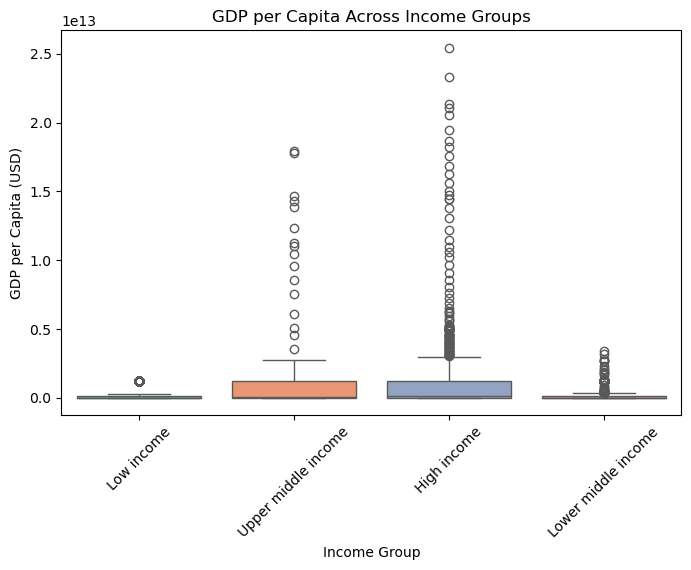

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Income group', y='GDP_current_US', data=df, palette='Set2')
plt.title('GDP per Capita Across Income Groups')
plt.xlabel('Income Group')
plt.ylabel('GDP per Capita (USD)')
plt.xticks(rotation=45)
plt.show()

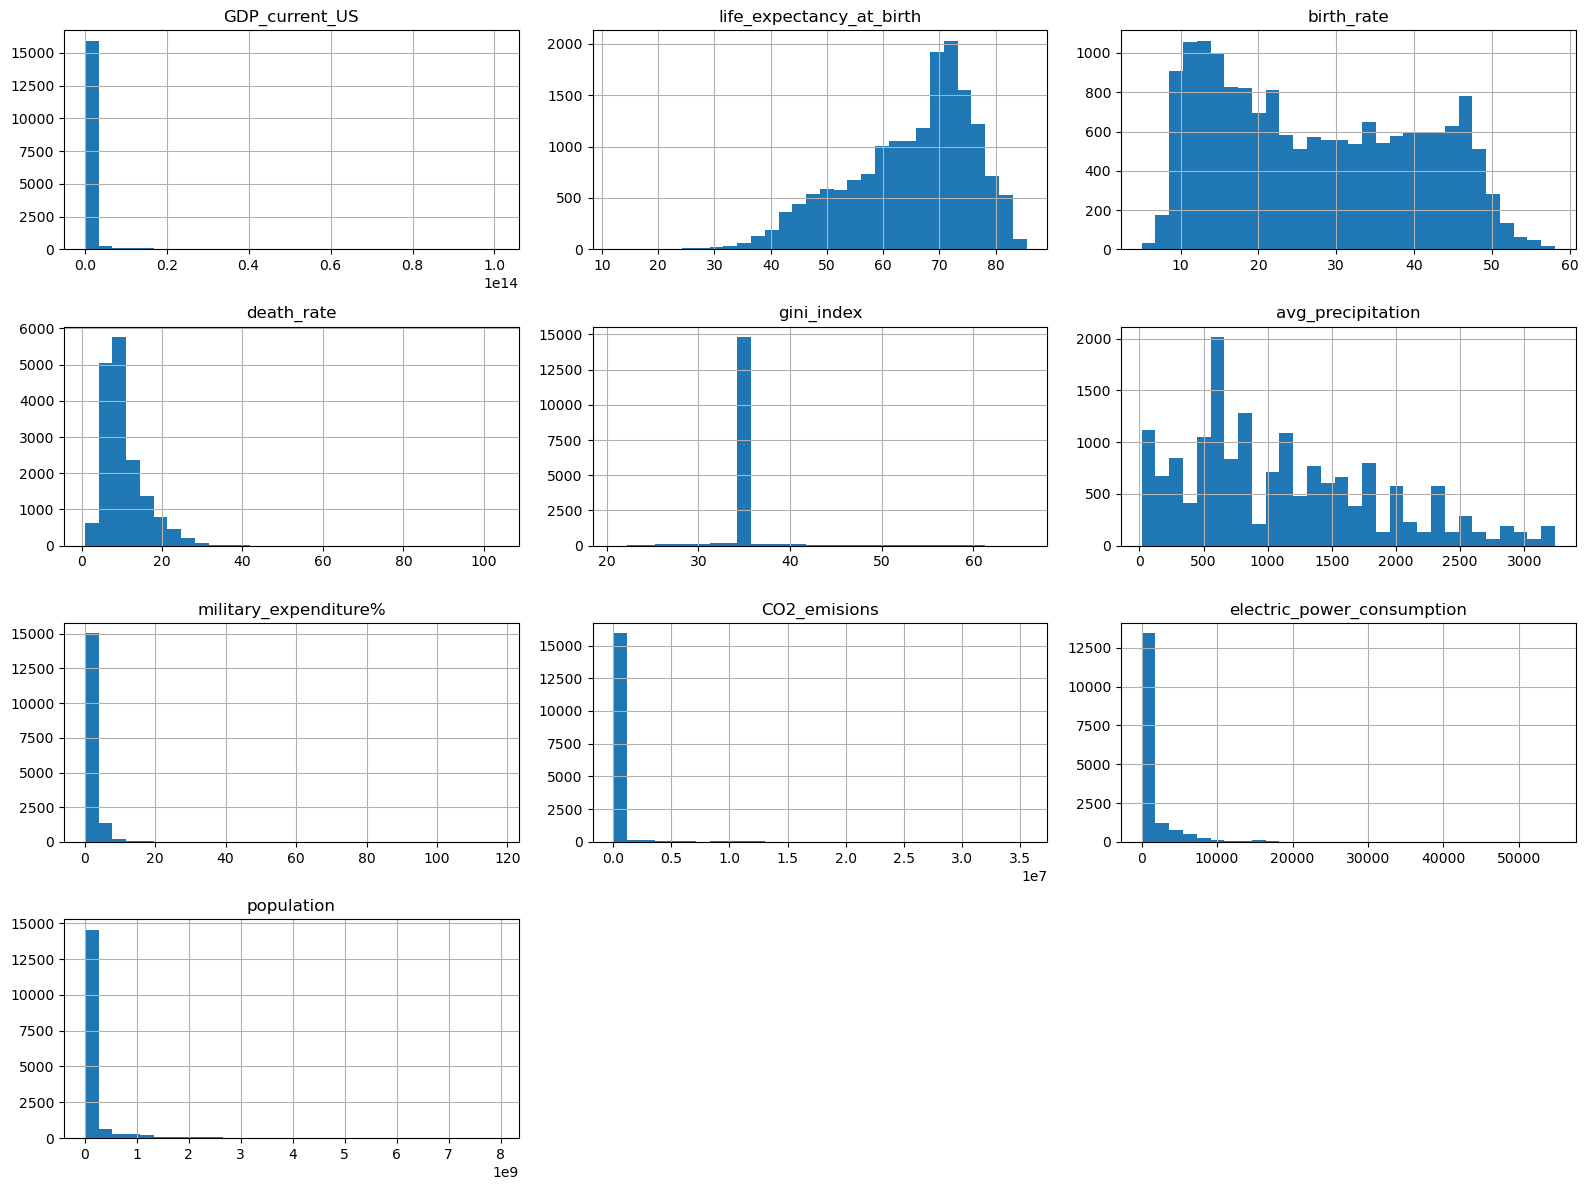

In [23]:
num_cols = [
    'GDP_current_US', 'life_expectancy_at_birth', 'birth_rate', 'death_rate',
    'gini_index', 'avg_precipitation', 'military_expenditure%', 
    'CO2_emisions', 'electric_power_consumption', 'population'
]

df[num_cols].hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()

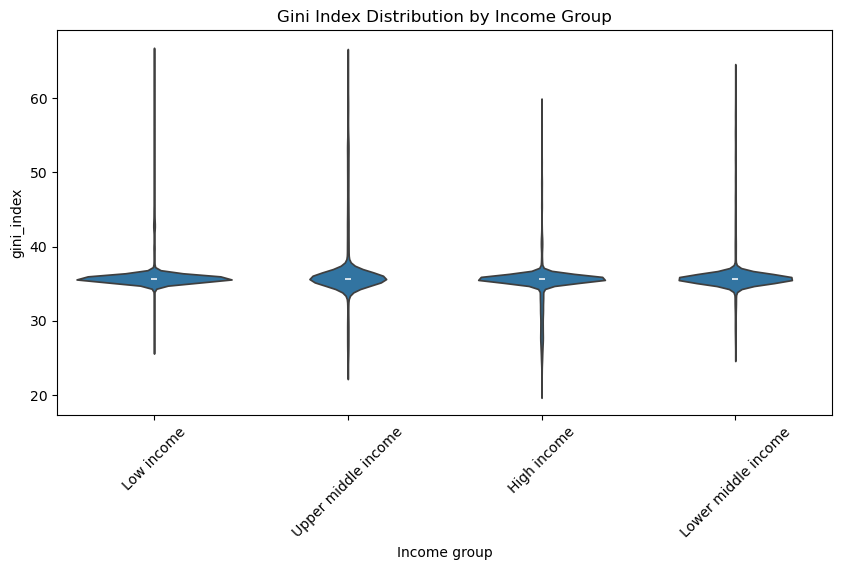

In [24]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='Income group', y='gini_index')
plt.xticks(rotation=45)
plt.title("Gini Index Distribution by Income Group")
plt.show()


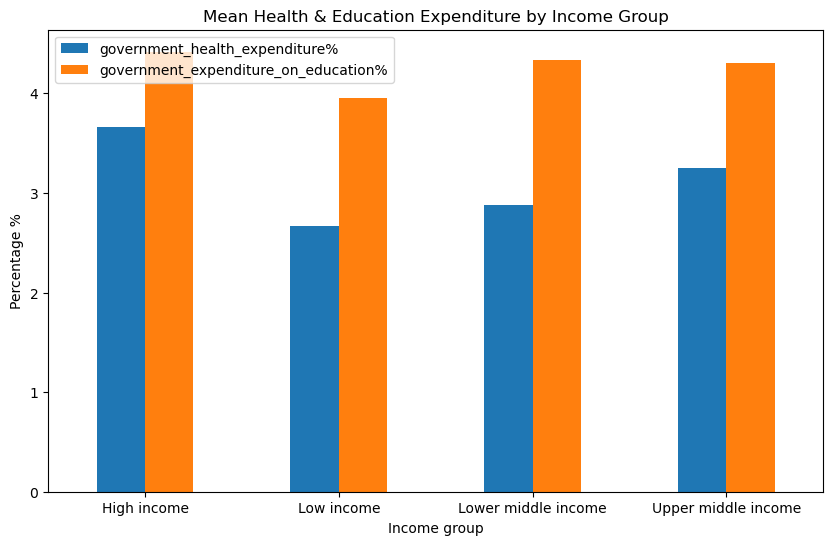

In [45]:
group_means = df.groupby('Income group')[
    ['government_health_expenditure%', 'government_expenditure_on_education%']].mean()

group_means.plot(kind='bar', figsize=(10,6))
plt.title("Mean Health & Education Expenditure by Income Group")
plt.ylabel("Percentage %")
plt.xticks(rotation=0)
plt.show()


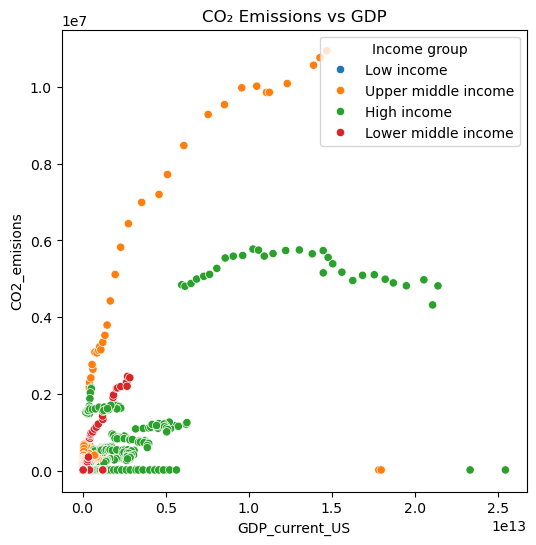

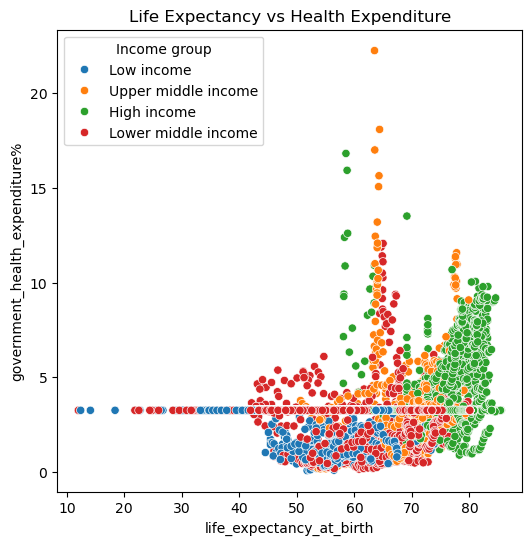

In [26]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x='GDP_current_US', y='CO2_emisions', hue='Income group')
plt.title("CO₂ Emissions vs GDP")
plt.show()

plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x='life_expectancy_at_birth',
                y='government_health_expenditure%', hue='Income group')
plt.title("Life Expectancy vs Health Expenditure")
plt.show()


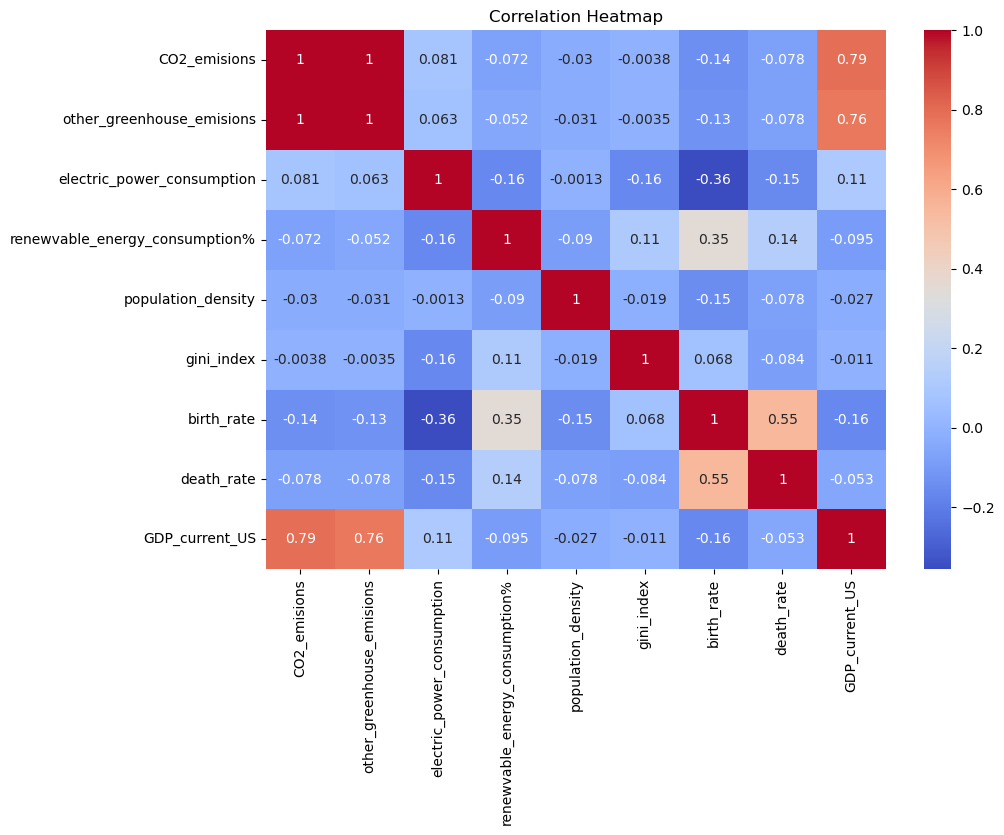

In [27]:
subset = df[
    ['CO2_emisions', 'other_greenhouse_emisions', 'electric_power_consumption',
     'renewvable_energy_consumption%', 'population_density', 'gini_index',
     'birth_rate', 'death_rate', 'GDP_current_US']
]

plt.figure(figsize=(10,7))
sns.heatmap(subset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
def world_map(df, column, title=None):
    fig = px.choropleth(
        df,
        locations="country",                # uses country names
        locationmode="country names",
        color=column,
        hover_name="country",
        color_continuous_scale="RdYlGn",
        title=title if title else f"World Map of {column}",
    )
    fig.update_layout(
        geo=dict(showframe=False, showcoastlines=False),
        title_x=0.5
    )
    fig.show()


# GDP per country
world_map(df, "GDP_current_US", "GDP (Current US$)")

# Life Expectancy
world_map(df, "life_expectancy_at_birth", "Life Expectancy at Birth")

# CO₂ Emissions
world_map(df, "CO2_emisions", "CO₂ Emissions (kt)")

# nternet Usage %
world_map(df, "individuals_using_internet%", "Internet Usage (%)")
